# Woeful Winds: What's WISC?
## Or: The StormEurope hazard subclass of climada.

Auth: Jan Hartman  
Date: 2018-04-26

This notebook will give a quick tour of the capabilities of the StormEurope hazard class. This includes facilities to apply probabilistic alterations to historical storms, but more about that later. Let's start by setting up our environment so that we can play a bit:

This is because I tend to start my Jupyter instance in another directory. (By the way, you should totally try JupyterLab, all the cool kids use it, apparently. No really, it's comfy, and as of April 2019, it's poised to go out of beta.)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

## Reading Data

StormEurope was written under the presumption that you'd start out with WISC storm footprint data in netCDF format. We first construct an instance and then point the reader at a directory containing compatible `.nc` files. Since there are other files in there, we must be explicit and use a globbing pattern; supplying incompatible files will make the reader fail.

The reader actually calls `climada.util.files_handler.get_file_names`, so it's also possible to hand it an explicit list of filenames, or a dirname, or even a list of glob patterns or directories. It's horses for courses, as they say on the seceding isle.

In [2]:
from climada.hazard import StormEurope
from climada.util.constants import WS_DEMO_NC

storm_instance = StormEurope()
storm_instance.read_footprints(WS_DEMO_NC)

2019-06-03 08:31:57,437 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf
2019-06-03 08:31:58,779 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/aznarsig/Documents/Python/climada_python/data/demo/fp_lothar_crop-test.nc
2019-06-03 08:32:00,335 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.


By the way, you can get data at <http://wisc.climate.copernicus.eu/>; we can't pull it for you, since (a) they require a login and (b) don't provide any interface besides HTML.

## Introspection

Let's quickly see what attributes this class brings with it:

In [3]:
storm_instance?

You could also try listing all permissible methods with `dir(storm_instance)`, but since that would include the methods from the `Hazard` base class, you wouldn't know what's special. The best way is to read the source: uncomment the following statement to read more.

In [4]:
# StormEurope??

## Into the Storm Severity Index

You'll probably be using the SSI, which can be set using `set_ssi`. For demonstration purposes, I want you to know all the kool stuff that we can do, so I'm showing all the default arguments. (Check the defaults using `storm_instance.calc_ssi?`, the method for which set_ssi is a wrapper.)

We won't be using the `plot_ssi` functionality just yet, because we only have two events; the graph really isn't informative. After this, we'll generate some more storms to make that plot more aesthetically pleasing.

In [5]:
storm_instance.set_ssi(
    method = 'wisc_gust',
    intensity = storm_instance.intensity, 
    # the above is just a more explicit way of passing the default
    on_land = False,
    threshold = 17,
    sel_cen = None
    # None is default. sel_cen could be used to subset centroids
)

## Probabilistic Storms

The meat and bones of this class lie in its ability to generate probabilistic storms from historical ones. This means that per historical event, we generate 29 new ones with altered intensities. Since it's just a bunch of vector operations, this is pretty fast. 

However, we should not return the entire probabilistic dataset in-memory: in trials, this used up 60 GB of RAM, thus requiring a great amount of swap space. Instead, we must select a country by setting the `reg_id` parameter to an ISO_N3 country code used in the [Natural Earth](http://naturalearthdata.com/) dataset. You can also supply a list of ISO codes. If you think your machine is up for the job of handling the whole dataset, set the `reg_id` parameter to `None`.

Since assigning each centroid a country ID is a rather inefficient affair, you may need to wait a minute or two for the entire WISC dataset to be processed. For this small one though, it runs pretty quickly. (See the nifty cell magic `%%time`)

2019-06-03 08:32:01,395 - climada.hazard.storm_europe - INFO - Commencing probabilistic calculations
2019-06-03 08:32:01,475 - climada.hazard.storm_europe - INFO - Generating new StormEurope instance


/Users/aznarsig/anaconda3/envs/climada_up/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


CPU times: user 1.55 s, sys: 41.2 ms, total: 1.59 s
Wall time: 1.37 s


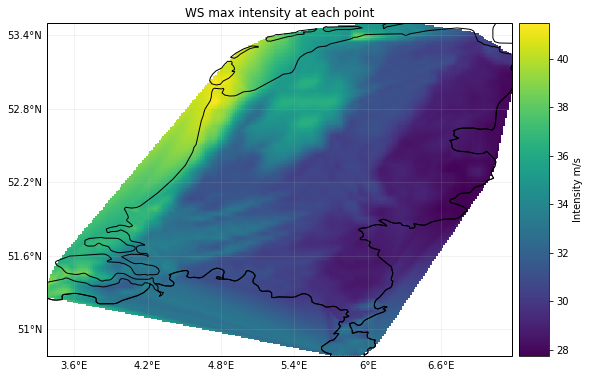

In [6]:
%%time
storm_prob = storm_instance.generate_prob_storms(reg_id=528)
storm_prob.plot_intensity(0)

As you can see, the returned plot is constrained to the Netherlands. In fact, when we merely plot the `centroids` of the `storm_prob` instance, we see that we have an even more specific selection than the above plot would have us believe:

(<Figure size 648x936 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x1c2a666a90>)

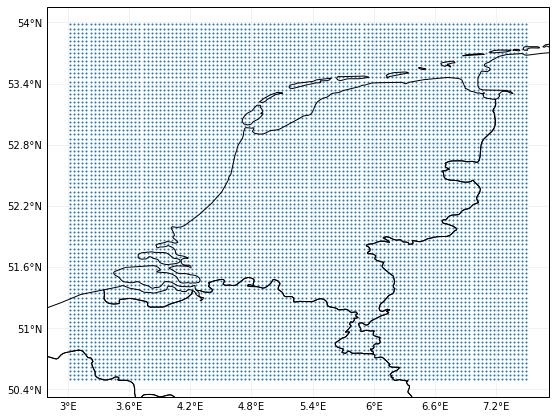

In [7]:
# storm_prob.centroids.plot()
storm_instance.centroids.plot()

We can get much more fancy in our calls to `generate_prob_storms`; the keyword arguments after `ssi_args` are passed on to `_hist2prob`, allowing us to tweak the probabilistic permutations.

In [8]:
ssi_args = {
    'on_land': False,
    'threshold': 17,
}

storm_prob_xtreme = storm_instance.generate_prob_storms(
    reg_id=[56, 528], # BEL and NLD
    spatial_shift=2,
    ssi_args=ssi_args,
    power=1.5,
    scale=0.3
)

2019-06-03 08:32:03,804 - climada.hazard.storm_europe - INFO - Commencing probabilistic calculations
2019-06-03 08:32:03,889 - climada.hazard.storm_europe - INFO - Generating new StormEurope instance


/Users/aznarsig/anaconda3/envs/climada_up/lib/python3.7/site-packages/scipy/sparse/compressed.py:208: RuntimeWarning: invalid value encountered in greater
  res = self._with_data(op(self.data, other), copy=True)


We can now check out the SSI plots of both these calculations. I expect a more pronounced difference betwee high and low end in the `_xtreme` dataset.

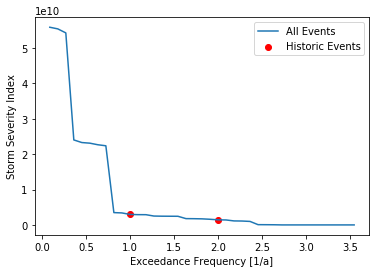

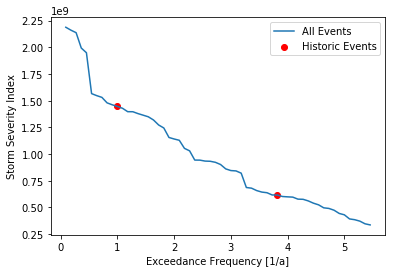

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2a302438>)

In [9]:
storm_prob_xtreme.plot_ssi(full_area=True)
storm_prob.plot_ssi(full_area=True)

That's all, folks! Dig into the code, which I hope won't be too obtuse.